In [22]:
from qiskit_experiments.library import EchoedCrossResonanceHamiltonian
import numpy as np
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon
from qiskit_dynamics import DynamicsBackend
from qiskit_dynamics import Solver
import numpy as np
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties
import jax
from qiskit import pulse
from qiskit import QuantumCircuit

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [23]:
dim = 3

v0 = 4.5e9
anharm0 = -0.243e9
r0 = 0.015e9

v1 = 4.402456766841759e9
anharm1 = -0.243e9
r1 = 0.015e9

J = -0.0025e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [24]:
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)

In [25]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [26]:
sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_sequential():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

    schedules.append(schedule)

job = backend.run(schedules, shots=100)
result = job.result()

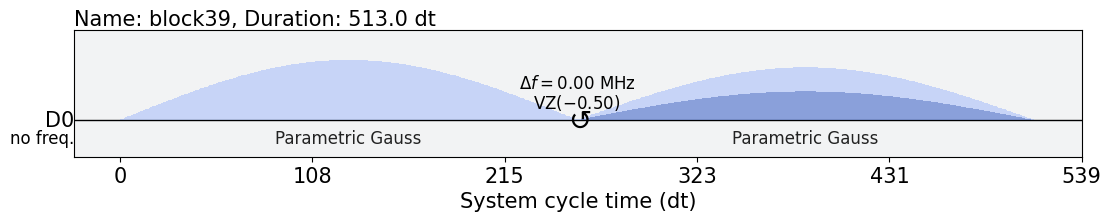

In [27]:
schedules[3].draw()


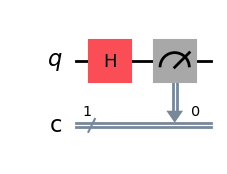

In [28]:
circ = QuantumCircuit(1, 1)
circ.h(0)
circ.measure([0], [0])

circ.draw("mpl")

In [29]:
with pulse.build() as h_q0:
    pulse.play(
        pulse.library.Gaussian(duration=256, amp=0.2, sigma=50, name="custom"),
        pulse.DriveChannel(0)
    )

circ.add_calibration("h", qubits=[0], schedule=h_q0)

In [30]:
res = backend.run(circ).result()
res.get_counts(0)

{'0': 996, '1': 28}

In [31]:
backend.target.add_instruction(HGate(), {(0,): InstructionProperties(calibration=h_q0)})

In [32]:
circ2 = QuantumCircuit(1, 1)
circ2.h(0)
circ2.measure([0], [0])

%time result = backend.run(circ2).result()

CPU times: total: 312 ms
Wall time: 580 ms


In [33]:
result.get_counts(0)


{'0': 983, '1': 41}

In [34]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties
target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [35]:
cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,duration,(),sx,160.00,default,True,2024-10-07 18:07:25.620389+0200,None
1,angle,(),x,0.00,default,True,2024-10-07 18:07:25.620389+0200,None
2,β,(),sx,0.00,default,True,2024-10-07 18:07:25.620389+0200,None
3,σ,(),sx,40.00,default,True,2024-10-07 18:07:25.620389+0200,None
4,duration,(),x,160.00,default,True,2024-10-07 18:07:25.620389+0200,None
5,amp,(),sx,0.25,default,True,2024-10-07 18:07:25.620389+0200,None
6,β,(),x,0.00,default,True,2024-10-07 18:07:25.620389+0200,None
7,amp,(),x,0.50,default,True,2024-10-07 18:07:25.620389+0200,None
8,σ,(),x,40.00,default,True,2024-10-07 18:07:25.620389+0200,None
9,angle,(),sx,0.00,default,True,2024-10-07 18:07:25.620389+0200,None


In [36]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal([0], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal([1], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [37]:
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

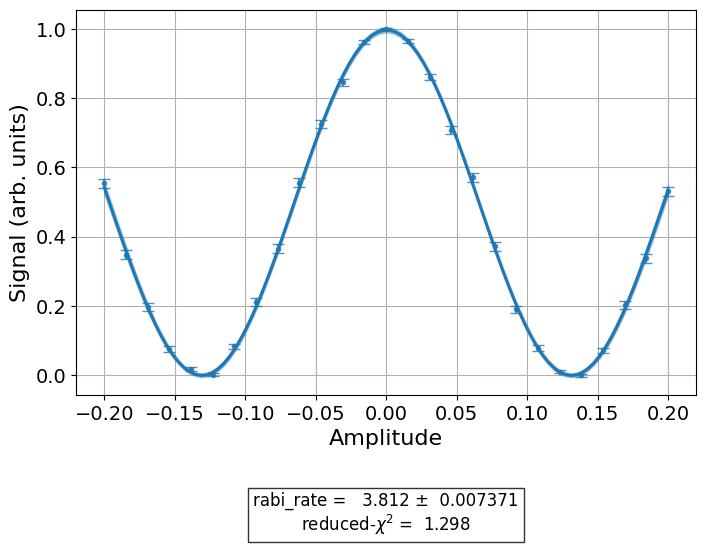

In [38]:
rabi0_data.figure(0)


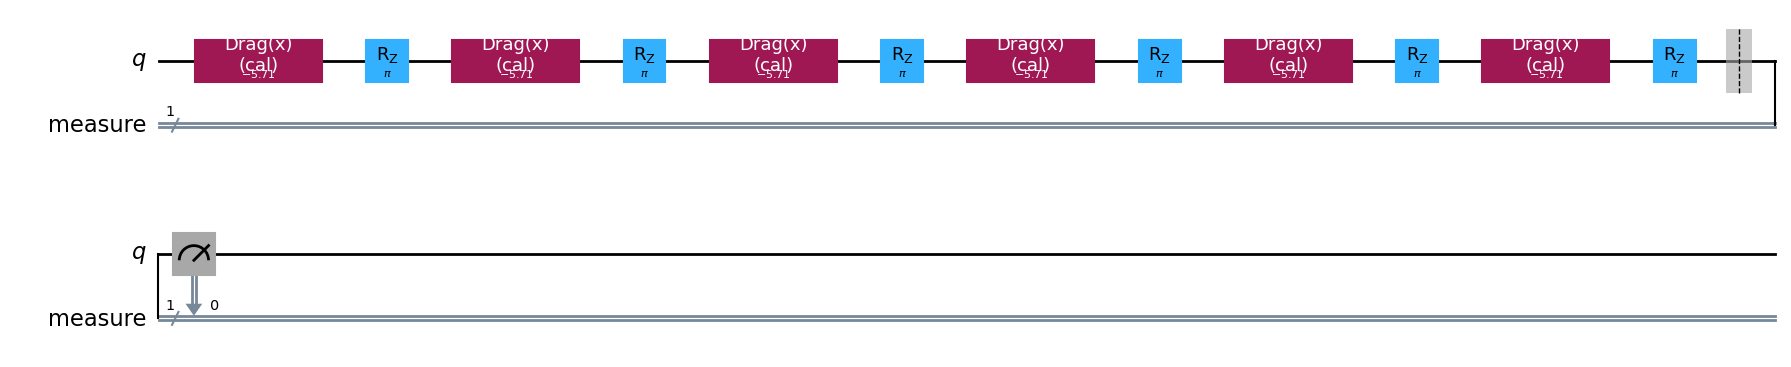

In [39]:
from qiskit_experiments.library.calibration import RoughDragCal

cal_drag0 = RoughDragCal([0], cals, backend=backend, betas=np.linspace(-20, 20, 15))
cal_drag1 = RoughDragCal([1], cals, backend=backend, betas=np.linspace(-20, 20, 15))

cal_drag0.set_experiment_options(reps=[3, 5, 7])
cal_drag1.set_experiment_options(reps=[3, 5, 7])

cal_drag0.circuits()[5].draw(output="mpl")

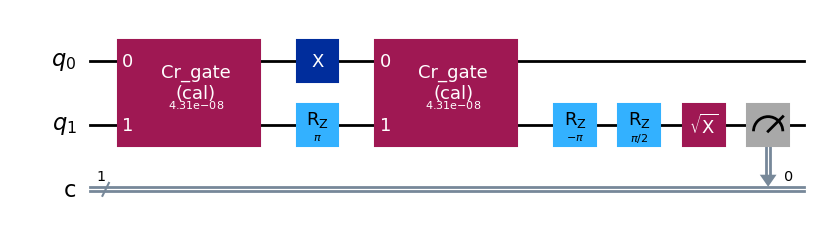

In [40]:
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})
cr_ham_experiment = EchoedCrossResonanceHamiltonian(
    physical_qubits=(0, 1),
    durations=np.linspace(1e-7, 4e-7, 17),
    backend=backend
)

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())
cr_ham_experiment.circuits()[0].draw("mpl")

In [41]:
data_cr = cr_ham_experiment.run().block_for_results()


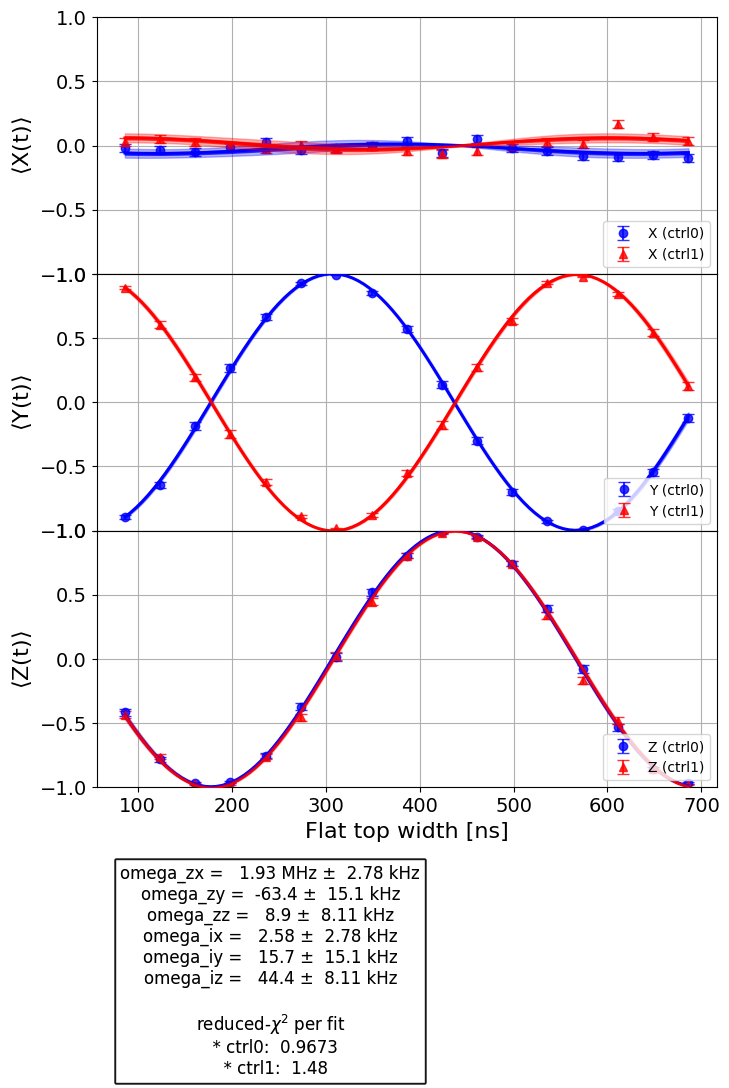

In [42]:
data_cr.figure(0)
